# 0. Faster-RCNN Person Detection

In [ ]:
import torch
from torch import nn


print(torch.__version__)

2.2.1+cu121


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Prepare Coco Dataset

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
try:
  import fiftyone as fo
  from fiftyone import zoo as foz
except:
  !pip install -q fiftyone
  import fiftyone as fo
  from fiftyone import zoo as foz

print(fo.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 9.8 MB/s eta 0:00:00
  Installing build dependenci

INFO:fiftyone.migrations.runner:Migrating database to v0.23.7


0.23.7


In [ ]:
# Download coco-2017-tran and coco-2017-validation
! rm -drf data
RANDOM_SEED=42
dataset_path='./data'

ds_train = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    dataset_name="COCO-2017-train",
    label_types=["detections"],
    classes=["person"],
    shuffle=True,
    dataset_dir=dataset_path,
    max_samples=4000,
    seed=RANDOM_SEED
)

ds_val = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    dataset_name="COCO-2017-validation",
    label_types=["detections"],
    classes=["person"],
    shuffle=True,
    dataset_dir=dataset_path,
    max_samples=500,
    seed=RANDOM_SEED
)

### 1.1 Filter labels

Pick person category only

In [ ]:
def pickPersonLabel(dataset):
  # Iterate over the dataset
  for sample in dataset:
      # Get the detections
      detections = sample.ground_truth.detections
      # Filter out non-person detections
      detections = [d for d in detections if d.label == "person"]
      # Update the detections
      sample.ground_truth.detections = detections
      # Save the sample
      sample.save()

pickPersonLabel(ds_train)
pickPersonLabel(ds_val)

In [ ]:
train_classes = ds_train.distinct("ground_truth.detections.label")
val_classes = ds_val.distinct("ground_truth.detections.label")

train_classes, val_classes

### 1.2 Export filtered data

In [ ]:
classes = ds_train.distinct("ground_truth.detections.label")

ds_train.export(
    export_dir="person/train",
    dataset_type=fo.types.COCODetectionDataset,
    label_field="ground_truth",
    split="train",
    classes=classes,
)

ds_val.export(
    export_dir="person/validation",
    dataset_type=fo.types.COCODetectionDataset,
    label_field="ground_truth",
    split="val",
    classes=classes,
)

In [ ]:
import zipfile
import os

folder_path = '/content/person'
zip_file_name = '/content/person.zip'

def zip_folder(folder_path, zip_file_name):
    with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

zip_folder(folder_path, zip_file_name)

In [ ]:
!cp /content/person_sm.zip /content/drive/MyDrive/Coco/
!ls -l /content/drive/MyDrive/Coco/

### 1.3 Load data from zip

In [ ]:
!rm -drf person
!rm *.zip
!cp /content/drive/MyDrive/Coco/person.zip .

rm: cannot remove '*.zip': No such file or directory


In [ ]:
import zipfile
from pathlib import Path

zip_file_path = Path('/content/person.zip')
extract_dir = Path('/content/person')
extract_dir.mkdir(parents=True, exist_ok=True)

# Function to extract the zip file
def unzip_file(zip_file_path, extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

unzip_file(zip_file_path, extract_dir)

### 1.4 Load data from zip (small)

In [ ]:
!rm -drf person
!rm *.zip
!cp /content/drive/MyDrive/Coco/person_sm.zip .

rm: cannot remove '*.zip': No such file or directory


In [ ]:
import zipfile
from pathlib import Path

zip_file_path = Path('/content/person_sm.zip')
extract_dir = Path('/content/person')
extract_dir.mkdir(parents=True, exist_ok=True)

# Function to extract the zip file
def unzip_file(zip_file_path, extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

unzip_file(zip_file_path, extract_dir)

## 2. Explore coco data

In [ ]:
import os
from pathlib import Path

def walk_through_dir(dir_path):
  """Walks through dir_path returning it's contents
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'")


person_path = Path('person')
walk_through_dir(person_path)

There are 2 directories and 0 files in 'person'
There are 1 directories and 1 files in 'person/validation'
There are 0 directories and 30 files in 'person/validation/data'
There are 1 directories and 1 files in 'person/train'
There are 0 directories and 70 files in 'person/train/data'


### 2.1 Explore coco annotation file

In [ ]:
from pycocotools.coco import COCO
from pathlib import Path

train_ann_file = person_path / Path("train/labels.json")
coco = COCO(annotation_file=train_ann_file)

# Explore categories
cat_ids = coco.getCatIds()
print(f"\nNumber of unique categories: {len(cat_ids)}")
print(f"Category ids: {cat_ids}")

# Display all available categories
cats = coco.loadCats(cat_ids)
cat_names = [cat["name"] for cat in cats]
print(f"Categories names: {cat_names}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Number of unique categories: 1
Category ids: [0]
Categories names: ['person']


In [ ]:
# Get the ID of all the images containing the object of the category
cat_id = cat_ids[0]
cat_ann = coco.loadCats([cat_id])[0]
cat_name = cat_ann["name"]

img_ids = coco.getImgIds(catIds=cat_id)
print(f"Number of train images '{cat_name}': {len(img_ids)}")

Number of train images 'person': 70


### 2.2 Visualizing coco image

In [ ]:
import random

random.seed(42)
random_id = random.choice(img_ids)

# Pick random image
img_id = img_ids[random_id]
img_info = coco.loadImgs([img_id])[0]
img_file_name = img_info["file_name"]
print(f"Image id: {img_id}, filename: {img_file_name}")


Image id: 16, filename: 000000217131.jpg


In [ ]:
# Get all the annotations for the specified image
ann_ids = coco.getAnnIds(imgIds=[img_id], iscrowd=None)
train_anns = coco.loadAnns(ann_ids)
print(f"Annotations for image id {img_id}: \n{train_anns}")


Annotations for image id 16: 
[{'id': 71, 'image_id': 16, 'category_id': 0, 'bbox': [427.4, 125.70000000000002, 42.0, 80.97], 'area': 3400.74, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 72, 'image_id': 16, 'category_id': 0, 'bbox': [363.6700000000001, 144.98, 25.49, 18.79], 'area': 478.95709999999997, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 73, 'image_id': 16, 'category_id': 0, 'bbox': [330.55, 129.87, 25.44, 23.1], 'area': 587.6640000000001, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 74, 'image_id': 16, 'category_id': 0, 'bbox': [311.49, 137.45, 31.13, 51.26], 'area': 1595.7238, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 75, 'image_id': 16, 'category_id': 0, 'bbox': [301.85, 128.31, 19.35, 24.12], 'area': 466.72200000000004, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 76, 'image_id': 16, 'category_id': 0, 'bbox': [293.56, 120.99000000000001, 12.379999999999999, 20.65], 'area': 255.64699999999996, 'iscrowd': 0, 'supercategory': 'person'}, {'id': 77, 'ima

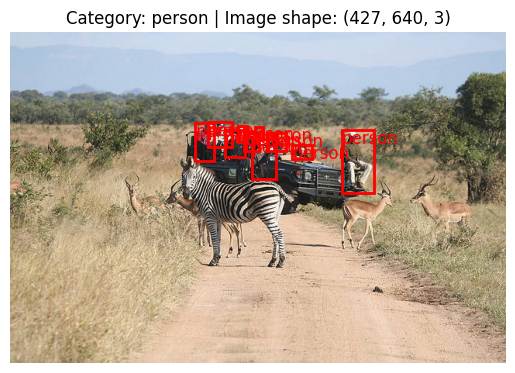

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img_path = person_path / Path("train/data")

im = Image.open(img_path / img_file_name)
im_as_array = np.asarray(im)

plt.title(f"Category: {cat_name} | Image shape: {im_as_array.shape}")
plt.axis(False)
plt.imshow(im_as_array)
ax = plt.gca()
for box in train_anns:
      x, y, w, h = box['bbox']
      rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
      ax.add_patch(rect)
      cat_id = box['category_id']
      plt.text(x, y, cat_name, fontsize=12, color='red', verticalalignment='top')

## 3. Transforming Data

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

### 3.1 Transforming data with albumentation

In [ ]:
# Write a transform for image
RANDOM_SEED = 42
RESIZE_SHAPE = 480

data_transform = A.Compose([
    # Resize our image to  800 x 800
    A.Resize(RESIZE_SHAPE, RESIZE_SHAPE),

    # Horizontal Flip
    A.HorizontalFlip(),

    # Turn the image into torch.Tensor
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=[]))

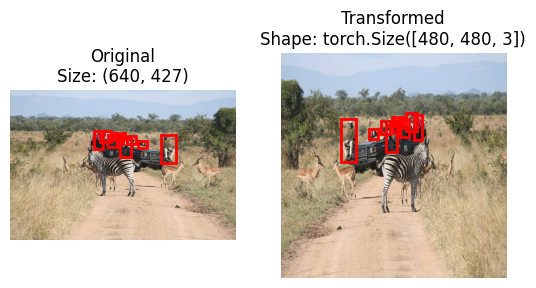

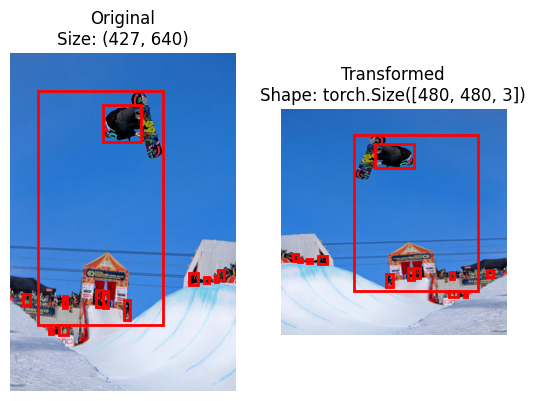

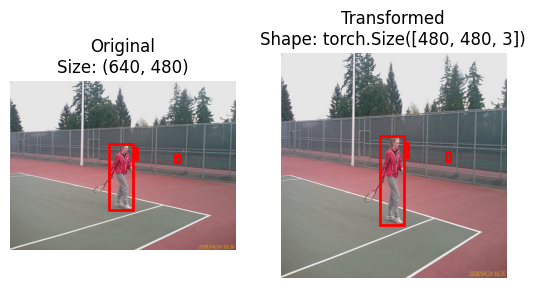

In [ ]:
def plot_transformed_images(image_ids, annon: COCO, transform, n=3, seed=42):
  """
    Selects random images from a path of images and loads/transofrms
    them then plots the original vs the transformed version
  """

  if seed:
    random.seed(seed)

  random_image_ids = random.sample(image_ids, k=n)
  for random_id in random_image_ids:
    img_id = img_ids[random_id]
    img_info = coco.loadImgs([img_id])[0]
    img_file_name = img_info["file_name"]
    image_path = Path("person/train/data") / img_file_name

    ann_ids = coco.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    bboxes = [ann['bbox'] for ann in anns]

    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)
      for bbox in bboxes:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax[0].add_patch(rect)


      # Transform and plot target image
      transformed = transform(image=np.asarray(f), bboxes=bboxes)
      transformed_image = transformed['image'].permute(1, 2, 0)
      transformed_bboxes = transformed['bboxes']
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")
      for bbox in transformed_bboxes:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax[1].add_patch(rect)

plot_transformed_images(image_ids=img_ids,
                        annon=train_ann_file,
                        transform=data_transform,
                        n=3,
                        seed=RANDOM_SEED)

### 3.2 Transforming data with torchvision

In [ ]:
from torchvision import tv_tensors
from torchvision.transforms import v2



tv_transform = v2.Compose([
    v2.Resize(size=(480, 480)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor()
])

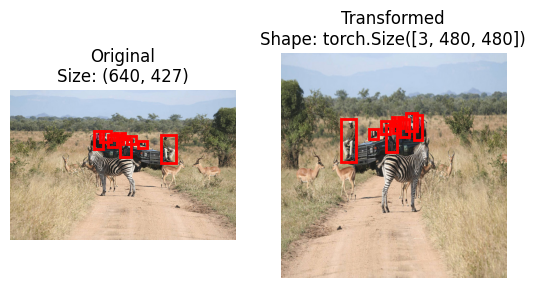

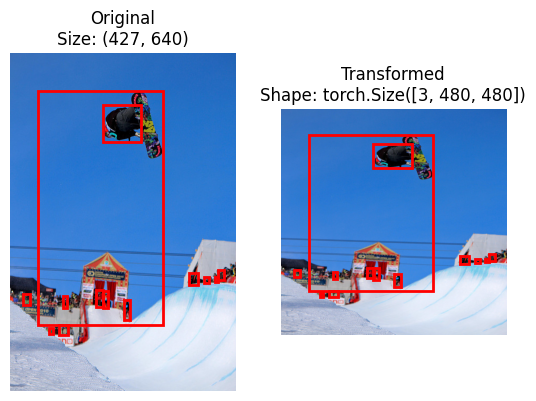

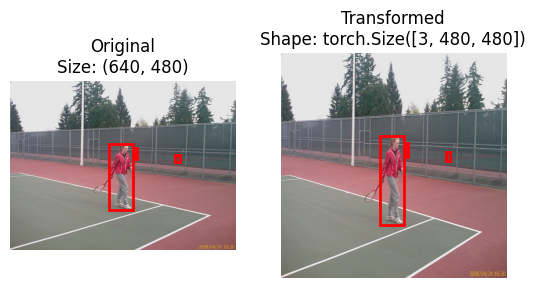

In [ ]:
def plot_transformed_images_v2(image_ids, annon: COCO, transform, n=3, seed=42):
  """
    Selects random images from a path of images and loads/transofrms
    them then plots the original vs the transformed version
  """

  if seed:
    random.seed(seed)

  random_image_ids = random.sample(image_ids, k=n)
  for random_id in random_image_ids:
    img_id = img_ids[random_id]
    img_info = coco.loadImgs([img_id])[0]
    img_file_name = img_info["file_name"]
    image_path = Path("person/train/data") / img_file_name

    ann_ids = coco.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    bboxes = [ann['bbox'] for ann in anns]

    with Image.open(image_path).convert('RGB') as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)
      for bbox in bboxes:
        x, y, w, h = bbox
        rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        ax[0].add_patch(rect)


      # Transform and plot target image
      image = tv_tensors.Image(f)
      boxes = []

      for bbox in bboxes:
        x, y, w, h = bbox
        x1, y1, x2, y2 = x, y, x+w, y+h
        boxes.append([x1, y1, x2, y2])

      boxes = tv_tensors.BoundingBoxes(boxes,
                                      format="XYXY",
                                      canvas_size=v2.functional.get_size(image))

      out_img, out_target  = transform(image, boxes)

      ax[1].imshow(out_img.permute(1, 2, 0))
      ax[1].set_title(f"Transformed\nShape: {out_img.shape}")
      ax[1].axis("off")
      for bbox in out_target:
        x1, y1, x2, y2 = bbox
        w = x2 - x1
        h = y2 - y1
        rect = plt.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=2)
        ax[1].add_patch(rect)

plot_transformed_images_v2(image_ids=img_ids,
                        annon=train_ann_file,
                        transform=tv_transform,
                        n=3,
                        seed=RANDOM_SEED)

## 4. Loading Image Data With Custom Dataset

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
import matplotlib.pyplot as plt
import numpy as np
import random

RANDOM_SEED=42

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 4.1 Creating a custom Dataset

In [ ]:
from pycocotools.coco import COCO
import numpy as np
from torchvision.transforms import v2
from torchvision import tv_tensors



class CocoCustomDataset(Dataset):
  def __init__(self,
               root: str,
               ann_file: str,
               transforms=None):
    # Setup image dir
    self.root = root
    # Load COCO annotations
    self.coco = COCO(ann_file)
    self.image_ids = list(sorted(self.coco.imgs.keys()))
    # Setup transforms
    self.transforms = transforms


  def __len__(self):
    return len(self.image_ids)

  def __getitem__(self, idx):
    img_id = self.image_ids[idx]
    img_info = self.coco.loadImgs(img_id)[0]
    img_path = os.path.join(self.root, img_info['file_name'])
    image = Image.open(img_path).convert('RGB')
    image = tv_tensors.Image(image)

     # Load annotations for the image
    ann_ids = self.coco.getAnnIds(imgIds=[img_id], iscrowd=None)
    anns = self.coco.loadAnns(ann_ids)

    target = {}



    boxes = []
    labels = []
    image_id = 0

    for ann in anns:
      x, y, w, h = ann['bbox']
      x1, y1, x2, y2 = x, y, x+w, y+h
      boxes.append([x1, y1, x2, y2])
      image_id = ann['image_id']

    target['boxes'] = tv_tensors.BoundingBoxes(boxes,
                                    format="XYXY",
                                    canvas_size=v2.functional.get_size(image))
    target['labels'] = torch.ones(len(anns), dtype=torch.int64) # NOTE: 1 for person
    target['image_id'] = image_id

    if self.transforms is not None:
      image, target = self.transforms(image, target)


    return image, target

### 4.2 Create transformation and load into custom dataset

In [ ]:
train_transforms = v2.Compose([
    v2.Resize(size=(480, 480)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor()
])

val_transforms = v2.Compose([
    v2.Resize(size=(480, 480)),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToPureTensor()
])

In [ ]:
train_data = CocoCustomDataset(root="person/train/data/",
                               ann_file="person/train/labels.json",
                               transforms=train_transforms)
validation_data = CocoCustomDataset(root="person/validation/data/",
                               ann_file="person/validation/labels.json",
                               transforms=val_transforms)
len(train_data), len(validation_data)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(70, 30)

In [ ]:
image, target = train_data[1]
print(f"Image:  {image} \nShape: {image.shape}")

Image:  tensor([[[0.9412, 0.9490, 0.9569,  ..., 0.9059, 0.9059, 0.9020],
         [0.9412, 0.9490, 0.9569,  ..., 0.9020, 0.9020, 0.8980],
         [0.9451, 0.9529, 0.9569,  ..., 0.9020, 0.8941, 0.8941],
         ...,
         [0.4549, 0.4980, 0.4745,  ..., 0.3804, 0.3608, 0.3843],
         [0.4667, 0.4745, 0.4863,  ..., 0.4353, 0.3569, 0.3882],
         [0.4706, 0.4549, 0.4667,  ..., 0.4078, 0.3686, 0.4196]],

        [[0.9216, 0.9255, 0.9373,  ..., 0.8863, 0.8863, 0.8824],
         [0.9216, 0.9294, 0.9373,  ..., 0.8863, 0.8863, 0.8824],
         [0.9255, 0.9333, 0.9373,  ..., 0.8863, 0.8784, 0.8784],
         ...,
         [0.4039, 0.4510, 0.4353,  ..., 0.3569, 0.3373, 0.3608],
         [0.4157, 0.4275, 0.4471,  ..., 0.4118, 0.3373, 0.3686],
         [0.4314, 0.4157, 0.4235,  ..., 0.3882, 0.3451, 0.4039]],

        [[0.9059, 0.9098, 0.9216,  ..., 0.8745, 0.8745, 0.8706],
         [0.9059, 0.9137, 0.9216,  ..., 0.8745, 0.8745, 0.8706],
         [0.9098, 0.9176, 0.9216,  ..., 0.8745, 0.

In [ ]:
print(f"Target: {target}")
print(f"Boxes: {target['boxes']} | shape: {target['boxes'].shape}")
print(f"Labels: {target['labels']} | shape: {target['labels'].shape}")
print(f"Image Id: {target['image_id']} | type: {type(target['image_id'])}")



Target: {'boxes': tensor([[183.1650, 171.8216, 298.7025, 479.5281]]), 'labels': tensor([1]), 'image_id': 2}
Boxes: tensor([[183.1650, 171.8216, 298.7025, 479.5281]]) | shape: torch.Size([1, 4])
Labels: tensor([1]) | shape: torch.Size([1])
Image Id: 2 | type: <class 'int'>


### 4.3 Create function to display random images

In [ ]:
# Create function to take random sample from dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display, purpose, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)
  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    image, target = dataset[targ_sample]

    image_adjusted = image.permute(1, 2, 0) # (HWC)

    plt.subplot(1, n, i+1)
    plt.imshow(image_adjusted)
    plt.axis(False)
    plt.title(f"shape:\n {image_adjusted.shape}")
    ax = plt.gca()
    for box in target['boxes']:
      x1, y1, x2, y2 = box
      width = x2 - x1
      height = y2 - y1
      rect = plt.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

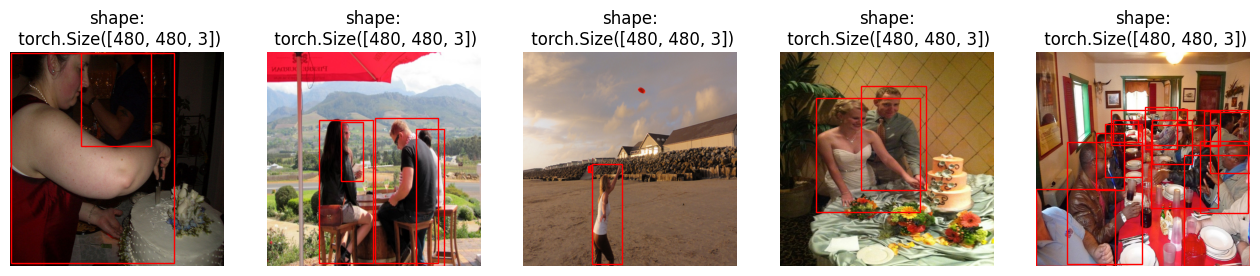

In [ ]:
display_random_images(train_data,
                      n=5,
                      seed=RANDOM_SEED)

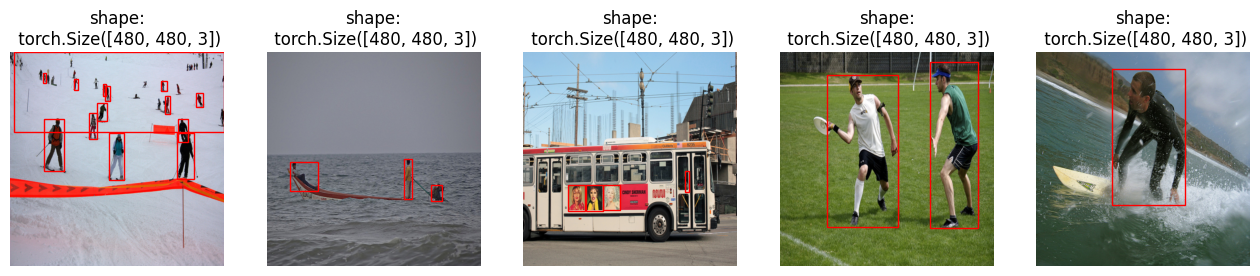

In [ ]:
display_random_images(validation_data,
                      n=5,
                      seed=None)

### 4.3 Turn custom dataset into DataLoader

In [ ]:
def collate_fn(batch):
  return batch

In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 4
NUM_WORKERS = os.cpu_count()


train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              collate_fn=lambda x: tuple(zip(*x)))
                              # collate_fn=collate_fn)

validation_dataloader = DataLoader(dataset=validation_data,
                              batch_size=1,
                              num_workers=NUM_WORKERS,
                              shuffle=False,
                              collate_fn=lambda x: tuple(zip(*x)))
                              # collate_fn=collate_fn)


len(train_dataloader), len(validation_dataloader)

(18, 30)

In [ ]:
# Get image and label from custom dataloader
images, targets = next(iter(train_dataloader))

print(f"Type of images: {type(images)}  Len: {len(images)}")
for img in images:
  print(f"\nImage: {img} | shape :  {img.shape}")


Type of images: <class 'tuple'>  Len: 4

Image: tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.4078, 0.4118, 0.3882,  ..., 0.3451, 0.4314, 0.4157],
         [0.4235, 0.4275, 0.3725,  ..., 0.4549, 0.4471, 0.4314],
         [0.3725, 0.3843, 0.3843,  ..., 0.4588, 0.4549, 0.4510]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.4078, 0.4078, 0.3882,  ..., 0.3608, 0.4471, 0.4353],
         [0.4235, 0.4235, 0.3725,  ..., 0.4706, 0.4667, 0.4549],
         [0.3725, 0.3882, 0.3843,  ..., 0.4745, 0.4784, 0.4784]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [

In [ ]:
print(f"Type of targets: {type(targets)} Len: {len(targets)}")
for target_list in targets:
  print(f"\nBoxes: {target_list['boxes']} | shape :  {target_list['boxes'].shape}")
  print(f"Labels: {target_list['labels']} | shape :  {target_list['labels'].shape}")

Type of targets: <class 'tuple'> Len: 4

Boxes: tensor([[109.3900, 309.3825, 200.3500, 480.0000],
        [  0.0000, 327.4275,  84.4200, 480.0000],
        [318.8900, 263.7525, 413.0200, 472.6125],
        [263.9800, 209.0700, 349.8800, 301.7775],
        [  0.0000, 235.1550,  85.1800, 354.5400],
        [ 58.4000, 249.6975, 160.5700, 413.0175],
        [106.2200, 236.6475, 126.8800, 267.8475],
        [267.7800, 290.9625, 292.6300, 376.6200],
        [161.5600, 231.7125, 194.2800, 272.9700],
        [235.5100, 230.0100, 261.3400, 282.1050],
        [230.4200, 237.3225, 243.0800, 249.5700],
        [324.4800, 209.2875, 391.8800, 243.3075],
        [188.1200, 252.6075, 276.1700, 477.1275]]) | shape :  torch.Size([13, 4])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) | shape :  torch.Size([13])

Boxes: tensor([[ 84.6432, 155.3060, 170.2656, 409.5036],
        [255.6960, 125.1181, 323.7312, 365.6675],
        [154.1088, 190.7566, 177.0624, 238.9012]]) | shape :  torch.Size([3, 4

## 5. Model Training

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

### 5.1 Load pre-trained FasterRCNN Resnet50

In [ ]:
from torchvision.models.detection import FasterRCNN

# Load a pre-trained Faster R-CNN model with a ResNet-50 backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Set the number of classes in your dataset (including background)
num_classes = 2  # For example, 1 class (object) + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 150MB/s]


### 5.2 Try forward pass dummy image

In [ ]:
import torch

# Define a dummy image tensor
dummy_image = torch.rand(1, 3, 800, 800).type(torch.float32).to(device)  # [batch_size, channels, height, width]

model.to(device)

model.eval()
with torch.inference_mode():
    output = model(dummy_image)

# Print the output shape
print("Output shape:", output)

Output shape: [{'boxes': tensor([[ 37.3687, 539.3419,  51.9796, 549.5356],
        [535.9820, 164.6021, 543.4074, 175.7485],
        [538.6686, 164.9435, 545.9878, 175.9294],
        [ 35.6871, 539.7789,  45.8401, 553.1967],
        [207.8218, 159.4782, 214.9699, 166.4986],
        [201.6965, 167.4914, 208.6841, 175.4207],
        [535.8708, 168.8011, 543.4672, 179.7404],
        [538.5120, 169.5499, 546.0814, 180.4820],
        [363.2466, 446.3862, 371.6363, 457.4037],
        [204.3112, 167.6592, 211.8431, 175.4430],
        [207.2722, 163.6557, 214.4054, 170.7888],
        [206.9359, 167.5276, 214.1833, 175.0545],
        [542.6753, 170.8102, 550.3322, 181.4872],
        [361.3744, 441.6815, 370.4844, 452.7656],
        [ 35.8093, 205.5743,  46.4690, 217.2581],
        [  7.4629, 639.8722, 101.5184, 763.4182],
        [761.3841, 482.8272, 799.3248, 800.0000],
        [204.0990, 164.8384, 211.3760, 172.0579],
        [210.8061, 162.9531, 217.9389, 170.5776],
        [164.2047, 160.17

### 5.3 Use torchinfo to get idea of model

In [ ]:
try:
  import torchinfo
except:
  !pip install -q torchinfo
  import torchinfo

from torchinfo import summary
summary(model, input_size=[(1, 3, 800, 800)])


Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              [100, 4]                  --
├─GeneralizedRCNNTransform: 1-1                         [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                                  [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                                 [1, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      [1, 64, 400, 400]         --
│    │    └─ReLU: 3-3                                   [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                              [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                             [1, 256, 200, 200]        (212,992)
│    │    └─Sequential: 3-6                             [1, 512, 100, 100]        1,212,416
│    │    └─Sequential: 3-7              

### 5.4 Create training loop function

In [ ]:

# Create train_step()
def train_step(model: FasterRCNN,
               dataloader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               epoch: int,
               device=device):

  # Put in train mode
  model.train()

  # Setup train loss
  train_loss = 0

  # Loop through dataloader batches
  for images, targets in dataloader:
    images = list([image.to(device) for image in images])
    targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    train_loss += losses.cpu().detach().numpy()

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()



  train_loss = train_loss / len(train_dataloader)

  return train_loss


### 5.5 Create evaluation function

In [ ]:
def compute_iou(box1, box2):
  """
  Compute IoU (Intersection over Union) between two bounding boxes.
  """
  # Get coordinates of intersection rectangle


  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])
  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])


  # Calculate area of intersection rectangle
  intersection_area = np.maximum(0, x2 - x1 + 1) * np.maximum(0, y2 - y1 + 1)

  # Calculate area of both bounding boxes
  box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
  box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

  # Calculate union area
  union_area = box1_area + box2_area - intersection_area

  # Calculate IoU
  iou = intersection_area / union_area

  return iou



In [ ]:
def compute_precision_recall(pred_boxes, true_boxes, iou_threshold=0.5):
    """
    Compute precision and recall for object detection task.
    """
    tp = 0  # True positives
    fp = 0  # False positives
    fn = 0  # False negatives

    # Match predictions with ground truths
    for pred_box in pred_boxes:
        matched = False
        for true_box in true_boxes:
            iou = compute_iou(pred_box, true_box)
            # print(f"calculated iou: {iou}")
            if iou > iou_threshold:
                tp += 1
                matched = True
                break
        if not matched:
            fp += 1

    # Calculate false negatives
    fn = len(true_boxes) - tp

    # Calculate precision and recall
    precision = tp / max(tp + fp, 1e-8)  # Avoid division by zero
    recall = tp / max(tp + fn, 1e-8)  # Avoid division by zero

    return precision, recall

In [ ]:
def average_precision_score(precisions, recalls):
  """
  Compute the average precision score given precision and recall values.
  """
  sorted_indices = np.argsort(recalls)
  recalls_sorted = recalls[sorted_indices]
  precisions_sorted = precisions[sorted_indices]

  recall_diff = np.diff(recalls_sorted)
  average_precision = np.sum(precisions_sorted[:-1] * recall_diff)

  return average_precision


### 5.6 Create validation loop function

In [ ]:
# Create eval function
def validation_step(model: FasterRCNN,
                    dataloader: torch.utils.data.DataLoader,
                    device=device):

   # Put in eval mode
   model.eval()
   with torch.inference_mode():

    precisions = []
    recalls = []

    for images, targets in dataloader:
      images = list([image.to(device) for image in images])
      outputs = model(images)
      targets = [{k: v.to("cpu") if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
      outputs = [{k: v.to("cpu") for k, v in o.items()} for o in outputs]

      for output, target in zip(outputs, targets):
        pred_boxes = output["boxes"].numpy()
        true_boxes = target["boxes"].numpy()

        precision, recall = compute_precision_recall(pred_boxes, true_boxes)
        precisions.append(precision)
        recalls.append(recall)

    map = average_precision_score(precisions=np.array(precisions),
                                  recalls=np.array(recalls))
    return map




### 5.5 Create `train()` functions

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          validation_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler.StepLR,
          epochs: int = 5,
          device=device):

  results = {
       "train_loss": [],
       "map_score": [],
   }

  for epoch in tqdm(range(epochs)):
    train_loss = train_step(model=model,
                            dataloader=train_dataloader,
                            optimizer=optimizer,
                            epoch=epoch,
                            device=device)
    scheduler.step()

    map_score = validation_step(model=model,
                    dataloader=validation_dataloader,
                    device=device)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Map: {map_score}")

    results["train_loss"].append(train_loss)
    results["map_score"].append(map_score)

  return results


### 5.6 Train model

In [ ]:
from tqdm.auto import tqdm

# Define the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(
    params, lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
    )

# Define LR Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
      optimizer,
      step_size=3,
      gamma=0.1
  )

# Send model to device
model.to(device)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model
model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      validation_dataloader=validation_dataloader,
                      optimizer=optimizer,
                      scheduler=lr_scheduler,
                      epochs=5,
                      device=device)

# End the timer and printout how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.7542 | Map: 0.5037151754461124
Epoch: 1 | Train loss: 0.4764 | Map: 0.605826531569284
Epoch: 2 | Train loss: 0.3957 | Map: 0.47105955531724253
Epoch: 3 | Train loss: 0.3385 | Map: 0.5332496057314517
Epoch: 4 | Train loss: 0.3293 | Map: 0.9448861278254423
Total training time: 80.566 seconds


In [ ]:
model_results

{'train_loss': [0.7541738061441315,
  0.47636041624678505,
  0.3956690861119164,
  0.3385399439268642,
  0.3292757541769081],
 'map_score': [0.5037151754461124,
  0.605826531569284,
  0.47105955531724253,
  0.5332496057314517,
  0.9448861278254423]}

In [ ]:
def plot_loss_map_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""

  epochs = range(1, len(results["map_score"]) + 1)

  plt.figure(figsize=(10, 5))

  # Plot train loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, results["train_loss"], 'r', label='Train Loss')
  plt.title('Train Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Train Loss')
  plt.legend()
  plt.grid()

  # Plot mAP
  plt.subplot(1, 2, 2)
  plt.plot(epochs, results["map_score"], 'b', label='mAP')
  plt.title('mAP vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('mAP')
  plt.legend()
  plt.grid()

  plt.tight_layout()
  plt.show()

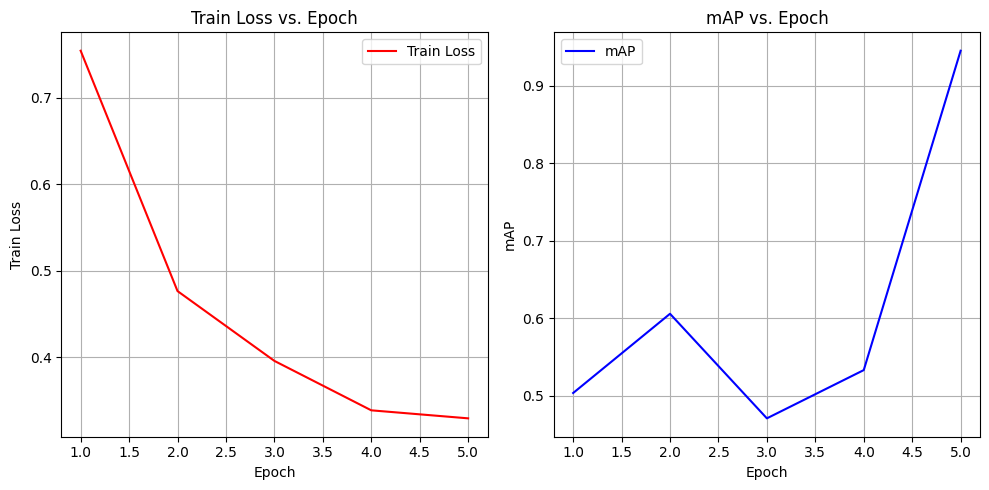

In [ ]:
plot_loss_map_curves(model_results)

## Test Model

### 6.1 Download test image from internet

In [ ]:
!rm *.jpg
!wget https://media.timeout.com/images/105906876/image.jpg

rm: cannot remove '*.jpg': No such file or directory
--2024-04-03 12:36:55--  https://media.timeout.com/images/105906876/image.jpg
Resolving media.timeout.com (media.timeout.com)... 52.84.229.105, 52.84.229.128, 52.84.229.34, ...
Connecting to media.timeout.com (media.timeout.com)|52.84.229.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1900834 (1.8M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.81M  1.46MB/s    in 1.2s    

2024-04-03 12:36:57 (1.46 MB/s) - ‘image.jpg’ saved [1900834/1900834]



### 6.2 Forward pass test image

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import ops
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image_path = "/content/image.jpg"

transform = transforms.Compose([
    transforms.ToTensor(),
])

image = Image.open(image_path).convert('RGB')
input_image = transform(image).unsqueeze(0)

print(input_image.shape)


model.eval()

# Start the timer
from timeit import default_timer as timer
start_time = timer()

with torch.inference_mode():
  predictions = model(input_image.to(device))

# End the timer and printout how long it took
end_time = timer()
print(f"Total inference time: {end_time-start_time:.3f} seconds")


outputs = [{k: v.to("cpu") for k, v in t.items()} for t in predictions]
out_bbox = outputs[0]['boxes']
out_scores = outputs[0]['scores']
# keep = ops.nms(out_bbox, out_scores, 0.00001)
min_score = 0.8
keep =  [i for i, score in enumerate(out_scores) if score > min_score]

result_boxes = [out_bbox[idx] for idx in keep]
print(out_scores)
print(keep)


torch.Size([1, 3, 1510, 2362])
Total inference time: 0.170 seconds
tensor([0.9898, 0.9879, 0.9877, 0.9875, 0.9812, 0.9801, 0.9751, 0.9731, 0.9422,
        0.9113, 0.7709, 0.6939, 0.6450, 0.6057, 0.5049, 0.4714, 0.4664, 0.4569,
        0.4424, 0.4278, 0.3096, 0.2920, 0.2538, 0.2474, 0.2382, 0.2315, 0.2260,
        0.2218, 0.2215, 0.2172, 0.2156, 0.2142, 0.1977, 0.1952, 0.1907, 0.1885,
        0.1748, 0.1586, 0.1576, 0.1424, 0.1401, 0.1391, 0.1377, 0.1352, 0.1308,
        0.1301, 0.1264, 0.1254, 0.1097, 0.1033, 0.0977, 0.0862, 0.0847, 0.0846,
        0.0827, 0.0821, 0.0812, 0.0779, 0.0757, 0.0742, 0.0735, 0.0709, 0.0668,
        0.0657, 0.0623, 0.0615, 0.0613, 0.0595, 0.0584, 0.0570, 0.0568, 0.0563,
        0.0562, 0.0548, 0.0503])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### 6.3 Visualizing prediction results

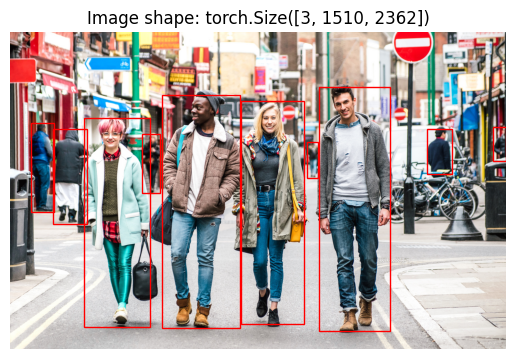

In [ ]:
plt.title(f"Image shape: {input_image.squeeze().shape}")
plt.axis(False)
plt.imshow(input_image.squeeze().permute(1,2,0))
ax = plt.gca()
for box in result_boxes:
      x1, y1, x2, y2 = box
      width = x2 - x1
      height = y2 - y1
      rect = plt.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

## 7. Saving model

### 7.1 Saving model `state_dict()`

In [ ]:
import torch
import torchvision.models as models

# Save the state_dict to a file
torch.save(model.state_dict(), 'faster_rcnn_sm_epoch_5.pth')



In [ ]:
!cp faster_rcnn_sm_epoch_3.pth /content/drive/MyDrive/Coco/

### 7.2 Loading model `state_dict()`

In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN

# Load a pre-trained Faster R-CNN model with a ResNet-50 backbone
loaded_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Set the number of classes in your dataset (including background)
num_classes = 2  # For example, 1 class (object) + background

# Get the number of input features for the classifier
in_features = loaded_model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
loaded_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 152MB/s]


In [ ]:
! cp /content/drive/MyDrive/Coco/*.pth .

In [ ]:
import torch
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
device


loaded_model.load_state_dict(torch.load('faster_rcnn_sm_epoch_5.pth', map_location=device))

<All keys matched successfully>

In [ ]:
torchvision.__version__

'0.17.1+cu121'

In [ ]:
! cp *.pth /content/drive/MyDrive/Coco/

### 7.3 Convert to ONNX

In [ ]:
!pip install -q onnx
!pip install -q onnxscript

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.2/561.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
torch_input = torch.randn(1, 3, 480, 640)

loaded_model.eval()
torch.onnx.export(loaded_model, torch_input, "faster_rcnn.onnx")

In [ ]:
! cp *.onnx /content/drive/MyDrive/Coco/

### 7.4 Testing ONNX model

In [ ]:
!cp  /content/drive/MyDrive/Coco/*.onnx .

In [ ]:
try:
  import onnxruntime
except:
  !pip install onnxruntime
  import onnxruntime



# Check if CUDA is available
use_cuda = torch.cuda.is_available()

# Specify the providers based on CUDA availability
providers = ['CUDAExecutionProvider'] if use_cuda else ['CPUExecutionProvider']
print(f"Providers: {providers}")

ort_session = onnxruntime.InferenceSession("/content/faster_rcnn.onnx", providers=providers)


Providers: ['CUDAExecutionProvider']


In [ ]:
!rm *.jpg
!wget https://media.timeout.com/images/105906876/image.jpg

rm: cannot remove '*.jpg': No such file or directory
--2024-04-03 13:35:04--  https://media.timeout.com/images/105906876/image.jpg
Resolving media.timeout.com (media.timeout.com)... 108.156.91.45, 108.156.91.78, 108.156.91.42, ...
Connecting to media.timeout.com (media.timeout.com)|108.156.91.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1900834 (1.8M) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]   1.81M  --.-KB/s    in 0.07s   

2024-04-03 13:35:04 (27.1 MB/s) - ‘image.jpg’ saved [1900834/1900834]



In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Load and preprocess the image
image_path = '/content/image.jpg'
image = Image.open(image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
])

input_tensor = transform(image).unsqueeze(0)

# Run inference
ort_inputs = {ort_session.get_inputs()[0].name: input_tensor.detach().cpu().numpy()}

# Start the timer
from timeit import default_timer as timer
start_time = timer()

ort_outs = ort_session.run(None, ort_inputs)

# End the timer and printout how long it took
end_time = timer()

print(f"Total inference time: {end_time-start_time:.3f} seconds")


Total inference time: 5.415 seconds


Onnx model take higher latency than pytorch model


In [ ]:
boxes, labels, scores = ort_outs[0], ort_outs[1], ort_outs[2]

min_score = 0.8
keep =  [i for i, score in enumerate(scores) if score > min_score]

result_boxes = [boxes[idx] for idx in keep]


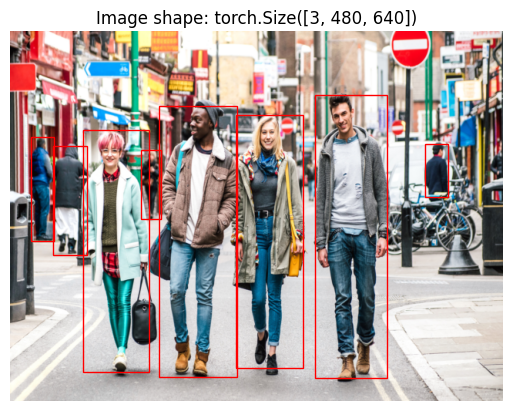

In [ ]:
import matplotlib.pyplot as plt

plt.title(f"Image shape: {input_tensor.squeeze().shape}")
plt.axis(False)
plt.imshow(input_tensor.squeeze().permute(1,2,0))
ax = plt.gca()
for box in result_boxes:
      x1, y1, x2, y2 = box
      width = x2 - x1
      height = y2 - y1
      rect = plt.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

## 8. Web Deployment

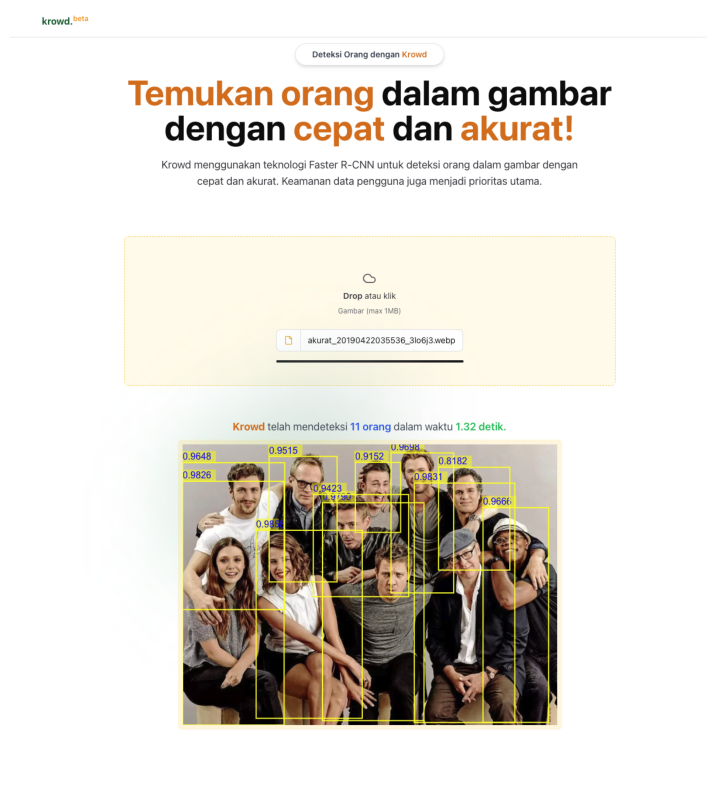

In [3]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/Screenshot 2024-04-04 at 9.01.11 AM.png'
image = Image.open(image_path).convert('RGB')
plt.figure(figsize=(16, 10))
plt.axis(False)
plt.imshow(image)